In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
# graph_data['graph_table']['Capacity'] = 2.5 * graph_data['graph_table']['Capacity']

graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [4]:
graph_data['graph_table'].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
1,3,1,5254.128418,16.057131,0.240297
2,1,7,7309.824707,16.058741,0.222813
3,7,1,7388.626953,15.865263,0.218902
4,1,9,1164.374878,17.455400,0.402046


In [5]:
graph_data['graph_table']['Orig Free Flow Time'] = graph_data['graph_table']['Free Flow Time']

In [6]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time,Orig Free Flow Time
0,1,3,4938.061523,16.106817,0.238965,0.238965
2,1,7,7309.824707,16.058741,0.222813,0.222813
4,1,9,1164.374878,17.455400,0.402046,0.402046


In [17]:
df.shape

(258, 6)

In [16]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
# T = handler.create_C(df, n, column_name='Free Flow Time')
# C = handler.create_C(df, n, column_name='length')

T = handler.get_T_from_shortest_distances(n, graph_data)

# np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [12]:
T[0][6]

TypeError: 'NoneType' object is not subscriptable

##### Запускаем Синхорна-Универсальный

In [47]:
np.set_printoptions(formatter={'all':lambda x: str(x)})
T_d = np.inf
eps = 10**(-5)
T_d_list = []
result_history = []
best_reconstruction_error_history = []
multi_stage_i = 0

T_orig = handler.get_T_from_shortest_distances(n, graph_data)
T_prev = np.copy(T_orig)
T = np.copy(T_orig)
alpha = 2.5402 #None
# alpha_prev = None
# alpha_prev_prev = None
# buf = None

best_matrix = None
min_reconstruction_error = np.inf
rec_list = []
# alpha_list = []
time_ratio_list = []
flow_excess_list = []

num_iter = 2500  # for sink
max_iter = 1000  # for univ
rec = None
rec_prev = np.zeros((n, n))

flows = None
flows_prev = np.zeros((df.shape[0]))
flows_d = []

while multi_stage_i < 5:
#     print('iter of multi-stage num: ', multi_stage_i)
    print('iter: ', multi_stage_i)
    
    s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)
    
#     alpha = count_alpha(multi_stage_i, T, T_prev, T_orig, alpha_prev, alpha_prev_prev)
#     alpha_list.append(alpha)
#     print(alpha, alpha_prev, alpha_prev_prev)
    
#     buf = alpha_prev
#     alpha_prev = alpha
#     alpha_prev_prev = buf
    
    if multi_stage_i == 0: 
        cost_matrix = np.nan_to_num( alpha * T_orig, nan=100)
    else:
        cost_matrix = np.nan_to_num( alpha * T, nan=100)
    
    rec = s.iterate(cost_matrix)
    
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er = np.sqrt(er / np.sum (np.nan_to_num(correspondence_matrix, nan=0.0)))
    
    print('Sinkhorn end, univ start \n')
    
    
    rec_list.append(np.linalg.norm(rec - rec_prev))
    rec_prev = np.copy(rec)
    print('rec - rec_prev: ', '\n', np.linalg.norm(rec - rec_prev))

    best_correcpondences_dict = handler.from_cor_matrix_to_dict(rec)

    model = md.Model(graph_data, best_correcpondences_dict, 
                     total_od_flow, mu = 0.25, rho = 0.15) # B, for stable D mu=0.0
    
    for i, eps_abs in enumerate(np.logspace(1,3,1)):
        
        print('eps_abs =', eps_abs)
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter}
        tic = time.time()
        result = model.find_equilibrium(solver_name = 'ugd', 
                                        solver_kwargs = solver_kwargs, 
                                        verbose = False)
        
    toc = time.time()
    
    T_d = np.linalg.norm(np.linalg.norm(T - T_prev))
    T_prev = T
    T_d_list.append(T_d)
    print('T - T_prev: ', np.linalg.norm(T - T_prev))

    result_history.append(result)
    
    graph_data['graph_table']['Free Flow Time'] = result['times']
    T = handler.get_T_from_shortest_distances(n, graph_data)
    
    flows = result['flows']
    flows_d.append(np.linalg.norm(flows - flows_prev))
    print('flows - flows_prev: ', np.linalg.norm(flows - flows_prev))
    flows_prev = np.copy(flows)
    
    multi_stage_i += 1

iter:  0
Sinkhorn end, univ start 

rec - rec_prev:  
 0.0
eps_abs = 10.0
T - T_prev:  0.0
flows - flows_prev:  45532.9157412922
iter:  1
Sinkhorn end, univ start 

rec - rec_prev:  
 0.0
eps_abs = 10.0
T - T_prev:  0.0
flows - flows_prev:  1389.1092196525042
iter:  2
Sinkhorn end, univ start 

rec - rec_prev:  
 0.0
eps_abs = 10.0
T - T_prev:  0.0
flows - flows_prev:  1384.5007983110631
iter:  3
Sinkhorn end, univ start 

rec - rec_prev:  
 0.0
eps_abs = 10.0
T - T_prev:  0.0
flows - flows_prev:  730.9505383130726
iter:  4
Sinkhorn end, univ start 

rec - rec_prev:  
 0.0
eps_abs = 10.0
T - T_prev:  0.0
flows - flows_prev:  802.8802441197731


In [54]:
rec_list

[2178.5511648194015,
 74.48652930583727,
 63.241157818914004,
 60.610239496183404,
 60.51753697508754]

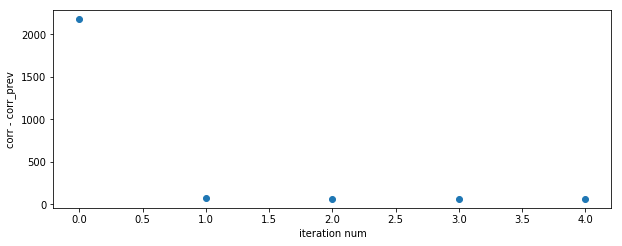

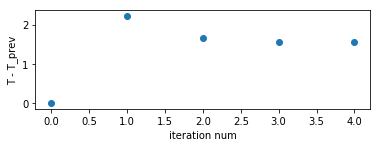

In [55]:
fig = plt.figure(figsize=(10, 8))
plt.figure(1)
plt.subplot(211)
plt.scatter(range(len(rec_list)), rec_list)
plt.ylabel('corr - corr_prev')
plt.xlabel('iteration num')
# plt.ylim(0.09, 0.2)
# plt.ylim(0, 0.0005)
# fig.savefig('KEV_res/multistage_er.png')
plt.figure(2)
plt.subplot(212)
plt.scatter(range(len(T_d_list)), T_d_list)
plt.ylabel('T - T_prev')
plt.xlabel('iteration num')
# plt.ylim(0.0032, 0.0033)
plt.show()

In [59]:
flows_d

[45532.9157412922,
 1389.1092196525042,
 1384.5007983110631,
 730.9505383130726,
 802.8802441197731]

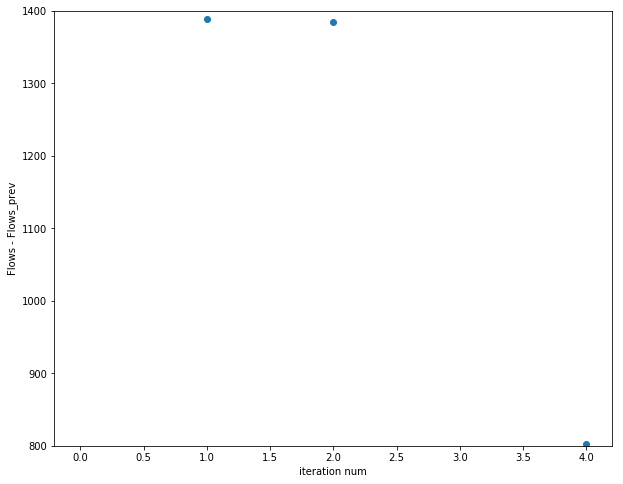

In [60]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(range(len(flows_d)), flows_d)
plt.ylabel('Flows - Flows_prev')
plt.xlabel('iteration num')
plt.ylim(800, 1400)
plt.show()
# fig.savefig('KEV_res/sink_reconstruct_er.png')

In [52]:
flows_d

[45532.9157412922,
 1389.1092196525042,
 1384.5007983110631,
 730.9505383130726,
 802.8802441197731]

In [ ]:
print(len(alpha_list), len(er_list))
fig = plt.figure(figsize=(10, 8))
plt.scatter(range(len(er_list)), er_list)
plt.ylabel('reconstruction error')
plt.xlabel('iteration num')
plt.show()
# fig.savefig('KEV_res/multi-stage-2-' + str(alpha) + 
#             'corr matrix reconstruction error' + '.png')